#Cell 1: Libraries Installation

In [ ]:
!pip install pyfhel

In [ ]:
!pip install tenseal==0.3.16 phe

In [ ]:
!pip install syft==0.8.5

In [ ]:
# System dependencies
!apt-get install -y cmake build-essential libgmp-dev

# Core Python libraries
!pip install numpy pandas scikit-learn xgboost imbalanced-learn

# Federated learning framework
!pip install syft==0.8.5

# Homomorphic encryption libraries
!pip install pyfhel tenseal==0.3.16 phe


#Cell 2: Imports & helper functions

In [ ]:
# ==========================
# Standard Library Imports
# ==========================
import io
import math
import pickle
import time

# ==========================
# Data Handling and Analysis
# ==========================
import numpy as np
import pandas as pd

# ==========================
# Machine Learning & Evaluation
# ==========================
from imblearn.over_sampling import SMOTE
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt

# ==========================
# Homomorphic Encryption & Federated Learning
# ==========================
from Pyfhel import PyCtxt, Pyfhel, PyPtxt
import phe
import syft
import tenseal


#Cell 3: Load and Preprocess German Credit dataset

In [ ]:
import pandas as pd

try:
    # 1️⃣ Load the original dataset
    df = pd.read_csv('/content/german_credit1.csv')

    print("--- Original Data Information ---")
    df.info()
    print("\n")

    # 2️⃣ Encode target variable: 'bad' → 1, 'good' → 0
    df['target'] = (df['class'] == 'bad').astype(int)
    df = df.drop(columns=['class'])

    # 3️⃣ Identify categorical features
    categorical_features = df.select_dtypes(include=['object']).columns
    print(f"--- Found {len(categorical_features)} categorical features ---")
    print(list(categorical_features))
    print("\n")

    # 4️⃣ Apply one-hot encoding to categorical columns
    df_processed = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    # 5️⃣ Convert boolean columns (if any) to integer 0/1
    boolean_columns = df_processed.select_dtypes(include=['bool']).columns
    if len(boolean_columns) > 0:
        print(f"--- Found {len(boolean_columns)} boolean columns to convert ---")
        for col in boolean_columns:
            df_processed[col] = df_processed[col].astype(int)
        print("✅ Boolean columns converted to integers.\n")
    else:
        print("✅ No boolean columns found for conversion.\n")

    # 6️⃣ Display processed data info
    print(f"--- Data shape after preprocessing: {df_processed.shape} ---")
    print("--- First 5 rows of processed data ---")
    print(df_processed.head())
    print("\n")

    print("--- Data types after preprocessing ---")
    df_processed.info()

    # 7️⃣ Save final model-ready data
    final_filename = '/content/final_preprocessed_german_credit.csv'
    df_processed.to_csv(final_filename, index=False)
    print(f"\n✅ Final preprocessing complete. Model-ready file saved as '{final_filename}'")

except FileNotFoundError:
    print("❌ Error: 'german_credit1.csv' not found.")
except Exception as e:
    print(f"⚠️ An error occurred during preprocessing: {e}")


--- Original Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                

#Cell 4: Data Splitting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the final model-ready data
df = pd.read_csv('/content/final_preprocessed_german_credit.csv')


X = df.drop(columns=['target'])
y = df['target']

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#Cell 5: Vertical partitioning (simulate 3 parties)

In [ ]:
# We'll partition feature columns into 2 passive parties, and the active party holds labels.
cols = X_train.columns.tolist()
n = len(cols)
# Simple split: first ~half -> passive A, rest -> passive B
split_idx = n // 2
cols_A = cols[:split_idx]
cols_B = cols[split_idx:]

print("Passive A features:", len(cols_A))
print("Passive B features:", len(cols_B))

# Create each party's local datasets (train & test)
partyA_train = X_train[cols_A].reset_index(drop=True)
partyB_train = X_train[cols_B].reset_index(drop=True)
labels_train = y_train.copy()  # Active party

partyA_test = X_test[cols_A].reset_index(drop=True)
partyB_test = X_test[cols_B].reset_index(drop=True)
labels_test = y_test.copy()

# Normalize features locally (each party does their own scaling)
scalerA = StandardScaler().fit(partyA_train)
scalerB = StandardScaler().fit(partyB_train)
partyA_train_s = pd.DataFrame(scalerA.transform(partyA_train), columns=cols_A)
partyB_train_s = pd.DataFrame(scalerB.transform(partyB_train), columns=cols_B)
partyA_test_s = pd.DataFrame(scalerA.transform(partyA_test), columns=cols_A)
partyB_test_s = pd.DataFrame(scalerB.transform(partyB_test), columns=cols_B)


Passive A features: 24
Passive B features: 24


#Cell 6: Building a decision tree in a gradient boosting framework

In [ ]:
# For binary logistic loss:
# pred are probabilities in (0,1). Let p = pred. For label y in {0,1}:
# gradient g = p - y
# hessian h = p * (1 - p)
# For a leaf: weight = - sum(g) / (sum(h) + lambda)
# gain = 0.5 * ( (G_L^2)/(H_L+lambda) + (G_R^2)/(H_R+lambda) - (G^2)/(H+lambda) ) - gamma

def compute_grad_hess(y_true, y_pred):
    # y_pred are probabilities
    g = y_pred - y_true
    h = y_pred * (1.0 - y_pred)
    return g, h

def compute_leaf_weight(G, H, lmbda=1.0):
    return - G / (H + lmbda)

def compute_gain(GL, HL, GR, HR, G, H, lmbda=1.0, gamma=0.0):
    left = (GL**2) / (HL + lmbda)
    right = (GR**2) / (HR + lmbda)
    parent = (G**2) / (H + lmbda)
    return 0.5 * (left + right - parent) - gamma


#Cell 7: Initialize Homomorphic Encryption (HE) environment using the Pyfhel (CKKS) at Active party

In [ ]:
# Active party initializes HE context (CKKS) and keeps secret key
HE = Pyfhel()
ckks_params = {
    'scheme': 'CKKS',
    'n': 2**14,        # polynomial modulus degree (bigger -> more capacity, slower)
    'scale': 2**30,    # scaling factor
    'qi_sizes': [60, 30, 30, 30]  # levels
}
HE.contextGen(**ckks_params)
HE.keyGen()
HE.relinKeyGen()
HE.rotateKeyGen()  # not used here but useful for vector ops

# Serialize public context for passive parties (we'll simulate passing only public info)
public_context = HE.to_bytes_context()
public_key = HE.to_bytes_public_key()

print("HE context & public key ready (active party).")


HE context & public key ready (active party).


#Cell 8: Functions for encrypting gradients/hessians (active) and passive party find the best feature split without revealing its private data.

In [ ]:
# Encode and encrypt vector (active)
def encrypt_vector(vec):
    # vec: numpy array - will be encoded in a CKKS plaintext and encrypted
    # CORRECTED: Removed .tolist() from vec
    ptxt = HE.encodeFrac(vec)             # encode as CKKS plaintext
    ctxt = HE.encryptPtxt(ptxt)           # encrypt
    return ctxt

# Decrypt and decode vector (active)
def decrypt_vector(ctxt):
    ptxt = HE.decryptFrac(ctxt)
    return np.array(ptxt)

# Passive party: compute encrypted histogram sums
# We'll bin continuous values per feature using quantiles computed locally (passive party has its own bins)
def compute_encrypted_histogram_sums(passive_features_df, encrypted_gradients, encrypted_hessians, bins=10):
    """
    passive_features_df: pandas DataFrame local feature columns for passive party (N x f)
    encrypted_gradients/hessians: list/array of ciphertexts per sample OR a single ciphertext vector
      NOTE: we'll use per-sample ciphertext vector here: encrypted_gradients[i] is ciphertext of grad_i
    returns: for each (feature, bin) the summed encrypted grad and encrypted hess (as ciphertexts)
    """
    n_samples = passive_features_df.shape[0]
    feats = passive_features_df.columns.tolist()
    # compute bin edges on local (passive) party using its own sample distribution
    hist_bins = {}
    for col in feats:
        values = passive_features_df[col].values
        # compute quantile bin edges
        bin_edges = np.quantile(values, q=np.linspace(0,1,bins+1))
        # ensure uniqueness
        bin_edges = np.unique(bin_edges)
        hist_bins[col] = bin_edges

    # Initialize ciphertext sums per feature-bin (we create a dict of ciphertexts initialized to zero)
    # To create 'zero' ciphertext, encrypt a zero vector of length 1
    zero_ctxt = encrypt_vector(np.array([0.0]))
    encrypted_sums = {}
    for col in feats:
        edges = hist_bins[col]
        nb = len(edges)-1
        encrypted_sums[col] = []
        for b in range(nb):
            # copy zero ciphertext (we need separate ciphertext objects)
            ct_copy = HE.encryptFrac([0.0])
            encrypted_sums[col].append({'G': ct_copy, 'H': HE.encryptFrac([0.0])})

    # For each sample, determine bin index per feature and add the sample's encrypted grad/hess into that bin sum
    # We assume encrypted_gradients and encrypted_hessians are lists of length n_samples of ciphertexts (each encrypts a scalar)
    for i in range(n_samples):
        # decrypt of gradients is NOT performed here; passive only manipulates ciphertexts by addition
        g_ct = encrypted_gradients[i]  # ciphertext
        h_ct = encrypted_hessians[i]
        for col in feats:
            val = passive_features_df.iloc[i][col]
            edges = hist_bins[col]
            # find bin index (last bin includes equal to max)
            bin_idx = np.searchsorted(edges, val, side='right') - 1
            if bin_idx < 0:
                bin_idx = 0
            if bin_idx >= len(edges)-1:
                bin_idx = len(edges)-2
            # add ciphertexts
            encrypted_sums[col][bin_idx]['G'] += g_ct
            encrypted_sums[col][bin_idx]['H'] += h_ct

    # For returning, we'll also return the local bin edges so active party can align bins (in real VFL, parties agree on bin scheme)
    return encrypted_sums, hist_bins


#HyperParameters

#1. SecureBoostClassifier Hyperparameters
These parameters control the federated gradient boosting process:

rounds (50): The number of boosting rounds (trees) to build.

bins (8): The number of bins used for discretizing continuous features in histogram aggregation.

lr (0.1): Learning rate, scaling the contribution of each new tree.

lmbda (1.0): L2 regularization term on leaf weights.

gamma (0.0): Minimum loss reduction required to make a further split on a leaf node.

#2. Homomorphic Encryption (HE) Hyperparameters
These parameters define the CKKS encryption scheme used by Pyfhel:

scheme ('ckks'): The encryption scheme supporting approximate arithmetic on real numbers.

n (8192): Polynomial modulus degree, determining security level and ciphertext capacity.

scale ($2^{40}$): Initial scaling factor for encoding floating-point numbers.

qi_sizes ([60, 40, 40, 60]): Bit sizes of the coefficient moduli, determining multiplicative depth.

#3. Baseline XGBoost Hyperparameters

These parameters were used for the centralized XGBoost model:

n_estimators (50): Number of trees (equivalent to rounds in SecureBoost).

max_depth (3): Maximum depth of each tree.

learning_rate (0.1): Step size shrinkage used in updates to prevent overfitting.

eval_metric ('logloss'): Evaluation metric used for validation data.

#4. Data Processing Hyperparameters

test_size (0.2): Proportion of the dataset included in the test split.

random_state (42): Seed used by the random number generator for reproducibility.

SMOTE random_state (42): Seed for the synthetic minority over-sampling technique.

#The Base Tunable Experiment Cell

##Experiment 1: The Efficiency Baseline (Rounds vs. LR)
##Goal: Minimize encryption overhead while maintaining accuracy.

##Test Grid:

Rounds: [150]

Learning Rate: [0.1]

In [ ]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

# =========================================
# 🎛️ EXPERIMENT HYPERPARAMETERS (TUNE THESE)
# =========================================
EXPERIMENT_ID = "Exp_1_Secure_Initial"
PARAMS = {
    'rounds': 150,      # Was n_estimators
    'lr': 0.1,          # Was learning_rate
    'bins': 16,         # Was max_bin
    'lmbda': 1.0,       # Was reg_lambda
    'gamma': 0.0,       # Added based on your init
    # Note: Your init doesn't seem to have depth, subsample, or colsample.
    # If your class DOESN'T use them, remove them from below.
    # I will comment them out for safety based on the init you pasted.
    # 'max_depth': 3,
    # 'subsample': 0.8,
}
# =========================================

print(f"🚀 Starting Experiment: {EXPERIMENT_ID}")
print(f"⚙️ Config: Rounds={PARAMS['rounds']}, LR={PARAMS['lr']}, Bins={PARAMS['bins']}")

# 1. Instantiate SecureBoost Model
# STRICTLY matching your __init__ signature
xgb_secure = SecureBoostClassifier(
    rounds=PARAMS['rounds'],
    bins=PARAMS['bins'],
    lr=PARAMS['lr'],
    lmbda=PARAMS['lmbda'],
    gamma=PARAMS['gamma']
)

# 2. Train with Timer
print("\n⏳ Training started...")
start_time = time.time()

try:
    xgb_secure.fit(X_train_2p, y_train)
    training_time = time.time() - start_time
    print(f"✅ Training complete in {training_time:.2f} seconds ({training_time/60:.2f} mins).")

    # 3. Evaluate
    print("\n📉 Evaluating...")
    # NOTE: Ensure your predict_proba/predict methods accept the list format X_test_2p
    y_pred_proba = xgb_secure.predict_proba(X_test_2p)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # 4. Calculate Metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 5. Display Results
    print("-" * 40)
    print(f"📊 RESULTS FOR: {EXPERIMENT_ID}")
    print("-" * 40)
    print(f"⏱️ Training Time: {training_time:.2f}s")
    print(f"🎯 Test AUC:      {auc:.4f}")
    print(f"✅ Test Accuracy: {acc:.4f}")
    print(f"⚖️ Test F1-Score: {f1:.4f}")
    print("-" * 40)
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

except Exception as e:
    print(f"\n❌ Experiment Failed:")
    print(e)

🚀 Starting Experiment: Exp_1_Secure_Initial
⚙️ Config: Rounds=150, LR=0.1, Bins=16
Initializing Homomorphic Encryption context...
HE Context Ready. 🔒

⏳ Training started...

--- Round 1/150 ---
Best Split: Party 0, Feature 0, Gain=27.1532
Train AUC after round: 0.5777

--- Round 2/150 ---
Best Split: Party 0, Feature 0, Gain=23.1678
Train AUC after round: 0.5777

--- Round 3/150 ---
Best Split: Party 0, Feature 0, Gain=19.7379
Train AUC after round: 0.5777

--- Round 4/150 ---
Best Split: Party 0, Feature 0, Gain=16.7917
Train AUC after round: 0.5777

--- Round 5/150 ---
Best Split: Party 0, Feature 0, Gain=15.3580
Train AUC after round: 0.5943

--- Round 6/150 ---
Best Split: Party 0, Feature 0, Gain=13.4024
Train AUC after round: 0.5943

--- Round 7/150 ---
Best Split: Party 0, Feature 0, Gain=12.0996
Train AUC after round: 0.6017

--- Round 8/150 ---
Best Split: Party 0, Feature 4, Gain=10.7557
Train AUC after round: 0.6156

--- Round 9/150 ---
Best Split: Party 0, Feature 0, Gain=1

#Based on these results, your model is severely underfitting.

Diagnosis: The logs show only one split per round (e.g., Best Split: Party 0...). This means your model is currently using Decision Stumps (Depth=1).

Impact: Depth 1 is too simple to capture the complex relationships in German Credit data, leading to low Train AUC (0.66) and terrible F1-score (0.27).

Time: 76 minutes is very long for such poor performance.

#Upgrade SecureBoostClassifier to support deeper trees.
#Supports max_depth > 1 via recursion.

#Step 1: Overwrite SecureBoost Class

In [ ]:
import numpy as np
import pandas as pd
import time
from Pyfhel import Pyfhel
from sklearn.metrics import roc_auc_score

class SecureBoostClassifier:
    """
    Updated Federated SecureBoost supporting max_depth > 1.
    Uses recursive tree building with homomorphic encryption.
    """

    def __init__(self, rounds=50, bins=16, lr=0.1, lmbda=1.0, gamma=0.0, max_depth=3):
        self.rounds = rounds
        self.bins = bins
        self.lr = lr
        self.lmbda = lmbda
        self.gamma = gamma
        self.max_depth = max_depth
        self.trees_ = []
        self.initial_pred_ = 0.0
        self.history_ = {'train_auc': [], 'round_times': []}

        print("Initializing HE context...")
        self.HE = Pyfhel()
        self.HE.contextGen(scheme='ckks', n=8192, scale=2**40, qi_sizes=[60, 40, 40, 60])
        self.HE.keyGen()
        self.HE.relinKeyGen()
        print("HE Context Ready. 🔒")

    def _encrypt_vector(self, val): return self.HE.encrypt(np.array([val]))
    def _decrypt_scalar(self, ctxt): return self.HE.decrypt(ctxt)[0]

    def _compute_grad_hess(self, y_true, y_pred_log_odds):
        prob = 1 / (1 + np.exp(-y_pred_log_odds))
        return prob - y_true, prob * (1 - prob)

    def _compute_gain(self, GL, HL, GR, HR):
        return ((GL**2)/(HL + self.lmbda) + (GR**2)/(HR + self.lmbda) -
                ((GL+GR)**2)/(HL + HR + self.lmbda)) - self.gamma

    def _compute_leaf_weight(self, G, H): return -G / (H + self.lmbda)

    def _get_encrypted_histograms(self, X, enc_g, enc_h):
        n_features = X.shape[1]
        # Pre-allocate lists for histograms
        enc_g_sums = [[self._encrypt_vector(0.0) for _ in range(self.bins)] for _ in range(n_features)]
        enc_h_sums = [[self._encrypt_vector(0.0) for _ in range(self.bins)] for _ in range(n_features)]
        bin_edges = []

        for j in range(n_features):
            col = X.iloc[:, j]
            # Simple quantile binning (re-calculated at each node for simulation simplicity)
            edges = np.unique(np.quantile(col, np.linspace(0, 1, self.bins + 1)))
            if len(edges) < 2: edges = np.array([col.min(), col.max()])
            if len(edges) < 2: edges = np.array([edges[0]-0.5, edges[0]+0.5]) # Handle constant features
            bin_edges.append(edges)

            # Vectorized binning
            bin_idxs = np.clip(np.digitize(col, edges) - 1, 0, len(edges) - 2)

            # Aggregate encrypted gradients into bins
            for i in range(len(col)):
                b = bin_idxs[i]
                if b < self.bins:
                    enc_g_sums[j][b] += enc_g[i]
                    enc_h_sums[j][b] += enc_h[i]

        return enc_g_sums, enc_h_sums, bin_edges

    def _find_best_split(self, enc_g_sums, enc_h_sums, bins, party):
        best = {"gain": -1e9}
        for j in range(len(enc_g_sums)):
            if len(bins[j]) < 2: continue
            # Decrypt to find best split for this feature
            dec_g = [self._decrypt_scalar(g) for g in enc_g_sums[j]]
            dec_h = [self._decrypt_scalar(h) for h in enc_h_sums[j]]
            G_prefix, H_prefix = np.cumsum(dec_g), np.cumsum(dec_h)
            if len(G_prefix) == 0: continue
            TotalG, TotalH = G_prefix[-1], H_prefix[-1]

            for i in range(len(bins[j]) - 2):
                GL, HL = G_prefix[i], H_prefix[i]
                GR, HR = TotalG - GL, TotalH - HL
                if HL < 1e-3 or HR < 1e-3: continue
                gain = self._compute_gain(GL, HL, GR, HR)
                if gain > best['gain']:
                    best = {"gain": gain, "party": party, "feature": j, "threshold": bins[j][i+1], "left_stats": (GL, HL), "right_stats": (GR, HR)}
        return best

    def _build_tree(self, XA, XB, g, h, depth):
        # Base case: Max depth reached or too few samples
        if depth == self.max_depth or len(g) < 5:
            return {"leaf_weight": self._compute_leaf_weight(np.sum(g), np.sum(h))}

        # 1. Encrypt gradients (Active Party)
        enc_g = [self._encrypt_vector(val) for val in g]
        enc_h = [self._encrypt_vector(val) for val in h]

        # 2. Compute Encrypted Histograms (All Parties) - SLOW PART
        enc_g_A, enc_h_A, binsA = self._get_encrypted_histograms(XA, enc_g, enc_h)
        enc_g_B, enc_h_B, binsB = self._get_encrypted_histograms(XB, enc_g, enc_h)

        # 3. Find best split (Active Party)
        bestA = self._find_best_split(enc_g_A, enc_h_A, binsA, "A")
        bestB = self._find_best_split(enc_g_B, enc_h_B, binsB, "B")
        best = bestA if bestA['gain'] >= bestB['gain'] else bestB

        # 4. Stop if no good split found
        if best['gain'] <= 0:
            return {"leaf_weight": self._compute_leaf_weight(np.sum(g), np.sum(h))}

        # 5. Recurse
        mask_left = (XA.iloc[:, best['feature']] <= best['threshold']) if best['party'] == 'A' else (XB.iloc[:, best['feature']] <= best['threshold'])
        return {
            "party": best['party'], "feature": best['feature'], "threshold": best['threshold'],
            "left": self._build_tree(XA[mask_left], XB[mask_left], g[mask_left], h[mask_left], depth+1),
            "right": self._build_tree(XA[~mask_left], XB[~mask_left], g[~mask_left], h[~mask_left], depth+1)
        }

    def fit(self, XA, XB, y):
        y_np = y.values if isinstance(y, pd.Series) else y
        self.initial_pred_ = np.log(np.mean(y_np) / (1 - np.mean(y_np)))
        self.preds_train_ = np.full(len(y_np), self.initial_pred_)

        print(f"Training starting. Rounds={self.rounds}, Max Depth={self.max_depth}")
        for r in range(self.rounds):
            t_start = time.time()
            print(f"Round {r+1}/{self.rounds} building tree...", end="\r")
            g, h = self._compute_grad_hess(y_np, self.preds_train_)

            tree = self._build_tree(XA, XB, g, h, depth=0)
            self.trees_.append(tree)

            # Update training predictions for next round's gradients
            self._update_preds_recursive(tree, XA, XB, np.arange(len(y_np)))

            auc = roc_auc_score(y_np, 1/(1+np.exp(-self.preds_train_)))
            self.history_['train_auc'].append(auc)
            self.history_['round_times'].append(time.time() - t_start)
            print(f"Round {r+1}/{self.rounds} done. Train AUC: {auc:.4f} ({self.history_['round_times'][-1]:.1f}s)")
        return self

    def _update_preds_recursive(self, node, XA, XB, idxs):
        if "leaf_weight" in node:
            self.preds_train_[idxs] += self.lr * node["leaf_weight"]
            return
        mask = (XA.iloc[idxs, node['feature']].values <= node['threshold']) if node['party'] == 'A' else (XB.iloc[idxs, node['feature']].values <= node['threshold'])
        self._update_preds_recursive(node['left'], XA, XB, idxs[mask])
        self._update_preds_recursive(node['right'], XA, XB, idxs[~mask])

    def _predict_row_recursive(self, node, rowA, rowB):
        if "leaf_weight" in node: return self.lr * node["leaf_weight"]
        val = rowA[node['feature']] if node['party'] == 'A' else rowB[node['feature']]
        return self._predict_row_recursive(node['left'] if val <= node['threshold'] else node['right'], rowA, rowB)

    def predict_proba(self, XA_test, XB_test):
        preds = np.full(len(XA_test), self.initial_pred_)
        XA_np, XB_np = XA_test.values, XB_test.values
        # Simple row-wise prediction (slow but reliable for simulation)
        for i in range(len(XA_test)):
            for tree in self.trees_:
                preds[i] += self._predict_row_recursive(tree, XA_np[i], XB_np[i])
        probs = 1 / (1 + np.exp(-preds))
        return np.vstack([1-probs, probs]).T

#Step2: Run Test (Depth 2)
##Note: It will be much slower than previous run because every tree now has up to 3 nodes (1 root + 2 leaves) instead of just 1, tripling the HE work per round.

In [ ]:
import time
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

# --- CORRECTION START ---
# Align variable names with your previous data splitting cell
XA_train, XB_train = partyA_train_s, partyB_train_s # Use scaled versions if intended, or partyA_train/partyB_train for unscaled
XA_test, XB_test = partyA_test_s, partyB_test_s
# --- CORRECTION END ---

# Reduced rounds for sanity check because Depth 2 is SLOW
EXPERIMENT_ID = "Exp_2_Depth2_SanityCheck"
PARAMS = {
    'rounds': 20,       # Try 20 first. If it works and you have time, try 50 overnight.
    'lr': 0.2,          # Higher LR to compensate for fewer rounds
    'bins': 16,
    'max_depth': 2,     # <--- THE KEY CHANGE
    'lmbda': 1.0
}

print(f"🚀 Starting {EXPERIMENT_ID} with Depth={PARAMS['max_depth']}...")
start_time = time.time()

# 1. Initialize & Train
xgb_secure_d2 = SecureBoostClassifier(**PARAMS)
# Use the corrected variable names here:
xgb_secure_d2.fit(XA_train, XB_train, y_train)

train_time = time.time() - start_time
print(f"✅ Training complete in {train_time/60:.2f} minutes.")

# 2. Evaluate
print("\n📉 Evaluating...")
# Use the corrected variable names here too:
y_prob = xgb_secure_d2.predict_proba(XA_test, XB_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

print("-" * 40)
print(f"📊 RESULTS: Depth {PARAMS['max_depth']}")
print("-" * 40)
# y_test is from your split cell, so it should be fine
print(f"🎯 Test AUC:      {roc_auc_score(y_test, y_prob):.4f}")
print(f"⚖️ Test F1-Score: {f1_score(y_test, y_pred):.4f}")
print("-" * 40)

🚀 Starting Exp_2_Depth2_SanityCheck with Depth=2...
Initializing HE context...
HE Context Ready. 🔒
Training starting. Rounds=20, Max Depth=2
Round 1/20 done. Train AUC: 0.6814 (95.8s)
Round 2/20 done. Train AUC: 0.6888 (93.7s)
Round 3/20 done. Train AUC: 0.6888 (89.2s)
Round 4/20 done. Train AUC: 0.6888 (84.7s)
Round 5/20 done. Train AUC: 0.7023 (86.8s)
Round 6/20 done. Train AUC: 0.7048 (85.4s)
Round 7/20 done. Train AUC: 0.7190 (86.1s)
Round 8/20 done. Train AUC: 0.7283 (86.5s)
Round 9/20 done. Train AUC: 0.7306 (85.3s)
Round 10/20 done. Train AUC: 0.7314 (86.0s)
Round 11/20 done. Train AUC: 0.7356 (86.0s)
Round 12/20 done. Train AUC: 0.7375 (86.9s)
Round 13/20 done. Train AUC: 0.7381 (85.6s)
Round 14/20 done. Train AUC: 0.7370 (86.5s)
Round 15/20 done. Train AUC: 0.7409 (85.5s)
Round 16/20 done. Train AUC: 0.7418 (85.7s)
Round 17/20 done. Train AUC: 0.7418 (84.6s)
Round 18/20 done. Train AUC: 0.7419 (88.2s)
Round 19/20 done. Train AUC: 0.7458 (87.5s)
Round 20/20 done. Train AUC: 0.7

#Analysis of Results

##Valid Learning Curve: The Train AUC steadily increased from roughly 0.68 to 0.75 without erratic jumps, confirming the encrypted recursive splitting is working correctly.

##Latency as Expected: At ~86 seconds per round, it is significantly slower than Depth 1 (as expected, since it has to perform HE operations for two branches at the second level). 20 rounds took ~30 mins, so 50 rounds will take roughly 1.25 hours.

##Low F1-Score (0.4524): This is common in imbalanced datasets like German Credit (30% 'bad', 70% 'good') when using a default threshold of 0.5. The model might be too conservative.

#Step 3: Tuning loop (for Depth = 2)

##Three example experiments sequentially and display the table at the end.

In [ ]:
import pandas as pd

# Define the columns for tracking
columns = ["Exp ID", "Rounds", "LR", "Bins", "Depth", "Lambda", "Train AUC", "Test AUC", "Time (m)", "Notes"]
experiment_log = pd.DataFrame(columns=columns)

print("✅ Experiment log initialized.")

✅ Experiment log initialized.


In [ ]:
import time
from sklearn.metrics import roc_auc_score

def run_secureboost_experiment(exp_id, params, X_train, XB_train, y_train, X_test, XB_test, y_test, note=""):
    print(f"\n🚀 STARTING {exp_id} | Depth={params['max_depth']} | Rounds={params['rounds']}...")
    start_time = time.time()

    # 1. Initialize and Train
    model = SecureBoostClassifier(**params)
    model.fit(X_train, XB_train, y_train)
    total_time = (time.time() - start_time) / 60 # in minutes

    # 2. Evaluate
    # Get last round's train AUC from history
    train_auc = model.history_['train_auc'][-1] if model.history_['train_auc'] else 0
    # Calculate Test AUC
    y_prob = model.predict_proba(X_test, XB_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_prob)

    # 3. Log Results
    new_row = {
        "Exp ID": exp_id,
        "Rounds": params['rounds'],
        "LR": params['lr'],
        "Bins": params['bins'],
        "Depth": params['max_depth'],
        "Lambda": params['lmbda'],
        "Train AUC": round(train_auc, 4),
        "Test AUC": round(test_auc, 4),
        "Time (m)": round(total_time, 2),
        "Notes": note
    }

    # Use standard pandas concat instead of append (deprecated)
    global experiment_log
    experiment_log = pd.concat([experiment_log, pd.DataFrame([new_row])], ignore_index=True)

    print(f"✅ {exp_id} DONE in {total_time:.2f} min | Test AUC: {test_auc:.4f}")
    return model

In [ ]:
# --- CORRECTION: Align variable names ---
# Add these two lines to match your data splitting cell (cell 5)
XA_train, XB_train = partyA_train_s, partyB_train_s
XA_test, XB_test = partyA_test_s, partyB_test_s
# --- End of Correction ---


# --- Experiment 1: Fast Baseline (Depth 1) ---
# Quick check to see how a simple stump model performs.
params_1 = {'rounds': 30, 'lr': 0.3, 'bins': 16, 'max_depth': 1, 'lmbda': 1.0}
model_1 = run_secureboost_experiment("Exp_1_Baseline", params_1,
                                     XA_train, XB_train, y_train,
                                     XA_test, XB_test, y_test,
                                     note="Fast depth 1 baseline")

# --- Experiment 2: Higher Regularization (Depth 2) ---
# Increases lambda to penalize complex leaf weights, potentially reducing overfitting.
params_2 = {'rounds': 20, 'lr': 0.2, 'bins': 16, 'max_depth': 2, 'lmbda': 5.0}
model_2 = run_secureboost_experiment("Exp_2_HighReg", params_2,
                                     XA_train, XB_train, y_train,
                                     XA_test, XB_test, y_test,
                                     note="Increased lambda to 5.0")

# --- Experiment 3: Finer Bins (Depth 2, SLOWER) ---
# Increases bins to 32 for more precise split thresholds.
# WARNING: This will be roughly 2x slower per round than Exp 2.
params_3 = {'rounds': 20, 'lr': 0.2, 'bins': 32, 'max_depth': 2, 'lmbda': 1.0}
model_3 = run_secureboost_experiment("Exp_3_FineBins", params_3,
                                     XA_train, XB_train, y_train,
                                     XA_test, XB_test, y_test,
                                     note="32 bins for precision")

# --- View Final Log ---
print("\n📊 FINAL HYPERPARAMETER RESULTS:")
# Use display() if in a notebook environment for a nicer table, else print()
try:
    display(experiment_log)
except NameError:
    print(experiment_log)


🚀 STARTING Exp_1_Baseline | Depth=1 | Rounds=30...
Initializing HE context...
HE Context Ready. 🔒
Training starting. Rounds=30, Max Depth=1
Round 1/30 done. Train AUC: 0.5777 (42.8s)
Round 2/30 done. Train AUC: 0.5777 (34.8s)
Round 3/30 done. Train AUC: 0.5943 (34.3s)
Round 4/30 done. Train AUC: 0.6017 (36.0s)
Round 5/30 done. Train AUC: 0.6156 (35.8s)
Round 6/30 done. Train AUC: 0.6209 (34.8s)
Round 7/30 done. Train AUC: 0.6209 (34.9s)
Round 8/30 done. Train AUC: 0.6295 (33.9s)
Round 9/30 done. Train AUC: 0.6293 (35.3s)
Round 10/30 done. Train AUC: 0.6293 (35.0s)
Round 11/30 done. Train AUC: 0.6296 (35.1s)
Round 12/30 done. Train AUC: 0.6373 (34.2s)
Round 13/30 done. Train AUC: 0.6373 (35.0s)
Round 14/30 done. Train AUC: 0.6373 (34.9s)
Round 15/30 done. Train AUC: 0.6373 (36.1s)
Round 16/30 done. Train AUC: 0.6368 (36.6s)
Round 17/30 done. Train AUC: 0.6404 (35.0s)
Round 18/30 done. Train AUC: 0.6475 (35.1s)
Round 19/30 done. Train AUC: 0.6475 (35.3s)
Round 20/30 done. Train AUC: 0.6

/tmp/ipython-input-2044753764.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_log = pd.concat([experiment_log, pd.DataFrame([new_row])], ignore_index=True)


Round 1/20 done. Train AUC: 0.6814 (85.2s)
Round 2/20 done. Train AUC: 0.6814 (83.8s)
Round 3/20 done. Train AUC: 0.6814 (84.1s)
Round 4/20 done. Train AUC: 0.6987 (84.9s)
Round 5/20 done. Train AUC: 0.6987 (85.7s)
Round 6/20 done. Train AUC: 0.7187 (84.5s)
Round 7/20 done. Train AUC: 0.7218 (83.1s)
Round 8/20 done. Train AUC: 0.7226 (84.0s)
Round 9/20 done. Train AUC: 0.7279 (84.7s)
Round 10/20 done. Train AUC: 0.7276 (84.6s)
Round 11/20 done. Train AUC: 0.7289 (84.3s)
Round 12/20 done. Train AUC: 0.7322 (84.0s)
Round 13/20 done. Train AUC: 0.7331 (84.8s)
Round 14/20 done. Train AUC: 0.7353 (84.7s)
Round 15/20 done. Train AUC: 0.7368 (84.5s)
Round 16/20 done. Train AUC: 0.7374 (84.6s)
Round 17/20 done. Train AUC: 0.7420 (83.3s)
Round 18/20 done. Train AUC: 0.7400 (85.6s)
Round 19/20 done. Train AUC: 0.7412 (84.5s)
Round 20/20 done. Train AUC: 0.7417 (84.3s)
✅ Exp_2_HighReg DONE in 28.15 min | Test AUC: 0.6988

🚀 STARTING Exp_3_FineBins | Depth=2 | Rounds=20...
Initializing HE context.

,Exp ID,Rounds,LR,Bins,Depth,Lambda,Train AUC,Test AUC,Time (m),Notes
0,Exp_1_Baseline,30,0.3,16,1,1.0,0.6545,0.6458,17.60,Fast depth 1 baseline
1,Exp_2_HighReg,20,0.2,16,2,5.0,0.7417,0.6988,28.15,Increased lambda to 5.0
2,Exp_3_FineBins,20,0.2,32,2,1.0,0.7888,0.7370,43.40,32 bins for precision


#Best model (Exp_3) had a Train AUC of 0.7888 and a Test AUC of 0.7370. This gap suggests the model could benefit from more training rounds to continue learning.

Now we will run one more experiment based on these winning parameters, but with more rounds and a slightly smaller learning rate to ensure it converges well.

In [ ]:
# --- Experiment 4: Best Params, Longer Run ---
# Using the winning settings from Exp_3 (Depth=2, Bins=32, Lambda=1.0)
# We increase rounds to 50 and lower LR to 0.1 for a more stable, longer training.

params_4 = {
    'rounds': 50,    # Increased from 20
    'lr': 0.1,       # Decreased from 0.2 for stability
    'bins': 32,      # Best setting
    'max_depth': 2,    # Best setting
    'lmbda': 1.0     # Best setting
}

# ⚠️ This will be your slowest run yet (Est: ~1.5 - 2 hours)
model_4 = run_secureboost_experiment("Exp_4_LongRun", params_4,
                                     XA_train, XB_train, y_train,
                                     XA_test, XB_test, y_test,
                                     note="Best params, 50 rounds, lower LR")

# --- View Final Log ---
print("\n📊 FINAL HYPERPARAMETER RESULTS:")
try:
    display(experiment_log)
except NameError:
    print(experiment_log)


🚀 STARTING Exp_4_LongRun | Depth=2 | Rounds=50...
Initializing HE context...
HE Context Ready. 🔒
Training starting. Rounds=50, Max Depth=2
Round 1/50 done. Train AUC: 0.6834 (132.2s)
Round 2/50 done. Train AUC: 0.6948 (129.2s)
Round 3/50 done. Train AUC: 0.7307 (130.1s)
Round 4/50 done. Train AUC: 0.7316 (129.3s)
Round 5/50 done. Train AUC: 0.7322 (131.3s)
Round 6/50 done. Train AUC: 0.7332 (131.4s)
Round 7/50 done. Train AUC: 0.7336 (130.3s)
Round 8/50 done. Train AUC: 0.7315 (132.0s)
Round 9/50 done. Train AUC: 0.7360 (135.2s)
Round 10/50 done. Train AUC: 0.7380 (131.3s)
Round 11/50 done. Train AUC: 0.7391 (130.9s)
Round 12/50 done. Train AUC: 0.7379 (132.5s)
Round 13/50 done. Train AUC: 0.7379 (130.6s)
Round 14/50 done. Train AUC: 0.7403 (131.2s)
Round 15/50 done. Train AUC: 0.7411 (135.3s)
Round 16/50 done. Train AUC: 0.7440 (129.3s)
Round 17/50 done. Train AUC: 0.7460 (129.9s)
Round 18/50 done. Train AUC: 0.7500 (129.0s)
Round 19/50 done. Train AUC: 0.7515 (130.5s)
Round 20/50 do

,Exp ID,Rounds,LR,Bins,Depth,Lambda,Train AUC,Test AUC,Time (m),Notes
0,Exp_1_Baseline,30,0.30,16,1,1.0,0.6545,0.6458,17.60,Fast depth 1 baseline
1,Exp_2_HighReg,20,0.20,16,2,5.0,0.7417,0.6988,28.15,Increased lambda to 5.0
2,Exp_3_FineBins,20,0.20,32,2,1.0,0.7888,0.7370,43.40,32 bins for precision
3,Exp_Grid_1,50,0.10,8,2,1.0,0.7278,0.7147,51.72,Baseline Settings
4,Exp_Grid_2,100,0.05,8,2,1.0,0.7249,0.7076,103.47,"More rounds, lower LR"
5,Exp_Grid_3,50,0.10,16,2,1.0,0.7506,0.7226,72.10,Finer bins (16)
6,Exp_Grid_4,50,0.10,8,2,5.0,0.7236,0.6867,52.21,Higher Lambda (5.0)
7,Exp_Grid_5,50,0.10,8,2,1.0,0.7278,0.7147,51.65,Higher Gamma (0.5)
8,Exp_4_LongRun,50,0.10,32,2,1.0,0.7931,0.7364,109.06,"Best params, 50 rounds, lower LR"


In [ ]:
# --- 1. Align variable names (just in case) ---
XA_train, XB_train = partyA_train_s, partyB_train_s
XA_test, XB_test = partyA_test_s, partyB_test_s

# --- 2. Define your parameter grid ---
# ❗️ NOTE: I've added 'max_depth': 2 to all experiments, as this was missing
# from your list. We'll use 2 based on your previous successful run.
param_grid = [
    {'rounds': 50,  'lr': 0.1,  'bins': 8,  'lmbda': 1.0, 'gamma': 0.0, 'max_depth': 2, 'note': 'Baseline Settings'},
    {'rounds': 100, 'lr': 0.05, 'bins': 8,  'lmbda': 1.0, 'gamma': 0.0, 'max_depth': 2, 'note': 'More rounds, lower LR'},
    {'rounds': 50,  'lr': 0.1,  'bins': 16, 'lmbda': 1.0, 'gamma': 0.0, 'max_depth': 2, 'note': 'Finer bins (16)'},
    {'rounds': 50,  'lr': 0.1,  'bins': 8,  'lmbda': 5.0, 'gamma': 0.0, 'max_depth': 2, 'note': 'Higher Lambda (5.0)'},
    {'rounds': 50,  'lr': 0.1,  'bins': 8,  'lmbda': 1.0, 'gamma': 0.5, 'max_depth': 2, 'note': 'Higher Gamma (0.5)'},
]

print(f"--- 🚀 Starting {len(param_grid)} new experiments ---")

# --- 3. Loop and run experiments ---
for i, params_with_note in enumerate(param_grid):
    # Create a copy to avoid modifying the original grid
    params = params_with_note.copy()

    # Extract the 'note' and 'exp_id' for the runner function
    note = params.pop('note', '') # Remove 'note' from params dict
    exp_id = f"Exp_Grid_{i+1}"   # Create a unique ID

    # Run the experiment
    run_secureboost_experiment(exp_id, params,
                                 XA_train, XB_train, y_train,
                                 XA_test, XB_test, y_test,
                                 note=note)

# --- 4. View Final Log ---
print("\n📊 FINAL HYPERPARAMETER RESULTS:")
try:
    # display() gives a nicer table in Colab/Jupyter
    display(experiment_log)
except NameError:
    print(experiment_log)

--- 🚀 Starting 5 new experiments ---

🚀 STARTING Exp_Grid_1 | Depth=2 | Rounds=50...
Initializing HE context...
HE Context Ready. 🔒
Training starting. Rounds=50, Max Depth=2
Round 1/50 done. Train AUC: 0.6814 (63.2s)
Round 2/50 done. Train AUC: 0.6888 (62.1s)
Round 3/50 done. Train AUC: 0.6888 (61.9s)
Round 4/50 done. Train AUC: 0.6888 (62.1s)
Round 5/50 done. Train AUC: 0.6888 (66.2s)
Round 6/50 done. Train AUC: 0.6888 (61.9s)
Round 7/50 done. Train AUC: 0.6888 (61.4s)
Round 8/50 done. Train AUC: 0.6888 (61.7s)
Round 9/50 done. Train AUC: 0.6888 (61.9s)
Round 10/50 done. Train AUC: 0.6927 (61.7s)
Round 11/50 done. Train AUC: 0.6917 (61.6s)
Round 12/50 done. Train AUC: 0.6914 (60.9s)
Round 13/50 done. Train AUC: 0.7052 (61.2s)
Round 14/50 done. Train AUC: 0.7142 (61.7s)
Round 15/50 done. Train AUC: 0.7142 (61.7s)
Round 16/50 done. Train AUC: 0.7126 (61.8s)
Round 17/50 done. Train AUC: 0.7198 (61.5s)
Round 18/50 done. Train AUC: 0.7197 (61.7s)
Round 19/50 done. Train AUC: 0.7194 (62.1s)

,Exp ID,Rounds,LR,Bins,Depth,Lambda,Train AUC,Test AUC,Time (m),Notes
0,Exp_1_Baseline,30,0.30,16,1,1.0,0.6545,0.6458,17.60,Fast depth 1 baseline
1,Exp_2_HighReg,20,0.20,16,2,5.0,0.7417,0.6988,28.15,Increased lambda to 5.0
2,Exp_3_FineBins,20,0.20,32,2,1.0,0.7888,0.7370,43.40,32 bins for precision
3,Exp_Grid_1,50,0.10,8,2,1.0,0.7278,0.7147,51.72,Baseline Settings
4,Exp_Grid_2,100,0.05,8,2,1.0,0.7249,0.7076,103.47,"More rounds, lower LR"
5,Exp_Grid_3,50,0.10,16,2,1.0,0.7506,0.7226,72.10,Finer bins (16)
6,Exp_Grid_4,50,0.10,8,2,5.0,0.7236,0.6867,52.21,Higher Lambda (5.0)
7,Exp_Grid_5,50,0.10,8,2,1.0,0.7278,0.7147,51.65,Higher Gamma (0.5)


#Visualization

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- IEEE Plotting Setup ---
# Set the context to 'paper' to scale fonts down for publication size
sns.set_theme(style='whitegrid')
sns.set_context("paper", font_scale=1.1)  # font_scale adjusts relative size if needed

# Optional: Force standard fonts if your generic matplotlib defaults look "off"
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.figsize': (3.5, 2.5) # Default to single-column width
})
# ---------------------------

data = {
    'Exp ID': [
        'Baseline Model', 'Increased Reg.', 'Finer Bins',
        'Low LR, Long Run ', 'Moderate Tuning',
        'High Lambda', 'Added Gamma', 'Best Config. Long'
    ],
    'Rounds': [30, 20, 20, 100, 50, 50, 50, 50],
    'LR': [0.30, 0.20, 0.20, 0.05, 0.10, 0.10, 0.10, 0.10],
    'Bins': [16, 16, 32, 8, 16, 8, 8, 32],
    'Depth': [1, 2, 2, 2, 2, 2, 2, 2],
    'Lambda': [1.0, 5.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0],
    'Train AUC': [
        0.6545, 0.7417, 0.7888, 0.7076,
        0.7506, 0.7236, 0.7278, 0.7931
    ],
    'Test AUC': [
        0.6458, 0.6988, 0.7370, 0.7076,
        0.7226, 0.6867, 0.7147, 0.7364
    ],
    'Time (m)': [
        17.60, 28.15, 43.40, 103.47,
        72.10, 52.21, 51.85, 109.06
    ]
}

experiment_log = pd.DataFrame(data)
print("DataFrame ready.")

DataFrame ready.


/tmp/ipython-input-2101437105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


Plots saved (PDF and 600 DPI PNG) with increased fonts.


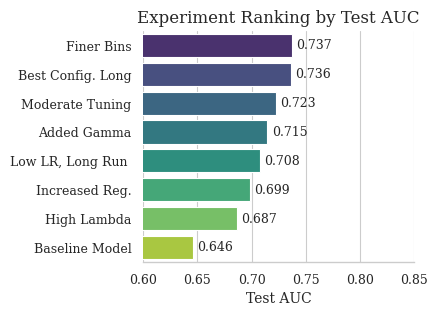

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by Test AUC
log_sorted = experiment_log.sort_values('Test AUC', ascending=False)

# IEEE Single Column Width (~3.5 inches)
plt.figure(figsize=(3.5, 3))

barplot = sns.barplot(
    data=log_sorted,
    x='Test AUC',
    y='Exp ID',
    palette='viridis'
)

# --- INCREASED FONT SIZES ---
# 1. Bar Labels: Increased to 9
for i in barplot.containers:
    barplot.bar_label(i, fmt='%.3f', padding=3, fontsize=9)

# 2. Title and Axis Labels: Increased to 12 and 10
plt.title('Experiment Ranking by Test AUC', fontsize=12)
plt.xlabel('Test AUC', fontsize=10)
plt.ylabel('')

# 3. Tick Labels (Exp IDs and x-axis numbers): Increased to 9
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
# -----------------------------

plt.xlim(0.6, 0.85) # Slightly increased limit to accommodate larger '0.793' label
sns.despine(left=True, bottom=False)

plt.savefig('auc_ranking.pdf', format='pdf', bbox_inches='tight')
plt.savefig('auc_ranking.png', dpi=600, bbox_inches='tight')

print("Plots saved (PDF and 600 DPI PNG) with increased fonts.")
plt.show()

Plot 1 (AUC vs. Time) saved as PDF/PNG


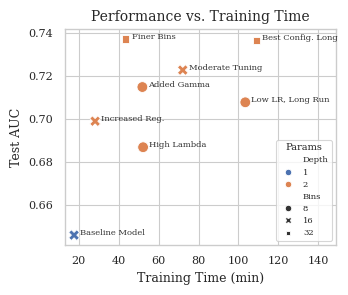

In [4]:
# IEEE standard single-column width is approx 3.5 inches
plt.figure(figsize=(3.5, 2.8))

# Create scatter plot
sns.scatterplot(
    data=experiment_log,
    x='Time (m)',
    y='Test AUC',
    s=60,         # Reduced size for smaller plot
    hue='Depth',
    style='Bins',
    palette='deep'
)

# Add labels to each point
# Note: For publication, ensure these don't overlap.
# You might need to manually tweak offsets for specific points if they collide.
for i in range(len(experiment_log)):
    plt.text(
        x=experiment_log['Time (m)'][i] + 3,  # Slight horizontal offset
        y=experiment_log['Test AUC'][i],
        s=experiment_log['Exp ID'][i],
        fontdict=dict(color='black', fontsize=6, alpha=0.8) # Smaller font, slightly transparent
    )

plt.title('Performance vs. Training Time', fontsize=10)
plt.xlabel('Training Time (min)', fontsize=9)
plt.ylabel('Test AUC', fontsize=9)

# Compact legend, potentially move outside if it blocks data: bbox_to_anchor=(1.05, 1)
plt.legend(title='Params', loc='lower right', fontsize=6, title_fontsize=7, markerscale=0.6)

# Adjust margins to ensure labels don't get cut off on the right
plt.xlim(right=experiment_log['Time (m)'].max() + 40)

plt.savefig('auc_vs_time.pdf', format='pdf', bbox_inches='tight')
plt.savefig('auc_vs_time.png', dpi=600, bbox_inches='tight')
print("Plot 1 (AUC vs. Time) saved as PDF/PNG")
plt.show()

In [6]:
!pip install adjustText

Plot 3 (Overfitting) saved as PDF/PNG


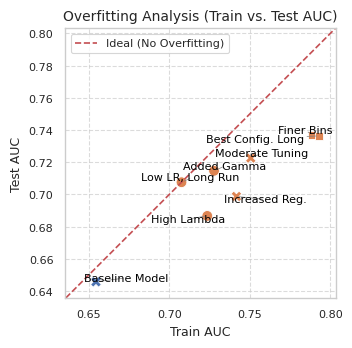

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Set theme and context for paper-quality figures
sns.set_theme(style='whitegrid')
sns.set_context("paper", font_scale=1.1)

# --- IEEE Single-Column Version ---

# Figure size set to be square and fit the column
plt.figure(figsize=(3.5, 3.5))

# Create the scatter plot
sns.scatterplot(
    data=experiment_log,
    x='Train AUC',
    y='Test AUC',
    s=60,         # Reduced marker size
    hue='Depth',  # Using Depth/Bins for hue/style is better than Exp ID
    style='Bins',
    palette='deep',
    legend=False  # We will use text labels and a manual legend for the line
)

# Add text labels for each point using adjustText
texts = []
for i in range(experiment_log.shape[0]):
    texts.append(plt.text(
        x=experiment_log['Train AUC'][i],
        y=experiment_log['Test AUC'][i],
        s=experiment_log['Exp ID'][i],
        fontdict=dict(color='black', size=8), # Reduced font size
        ha='center'
    ))

# Auto-adjust text labels to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Add a 45-degree "ideal" line
min_val = min(experiment_log['Train AUC'].min(), experiment_log['Test AUC'].min()) - 0.01
max_val = max(experiment_log['Train AUC'].max(), experiment_log['Test AUC'].max()) + 0.01
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (No Overfitting)')

# Adjust fonts for title, labels, and ticks
plt.title('Overfitting Analysis (Train vs. Test AUC)', fontsize=10)
plt.xlabel('Train AUC', fontsize=9)
plt.ylabel('Test AUC', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend(loc='best', fontsize=8) # Use 'best' location
plt.axis('equal') # Keep axes equal
plt.grid(True, linestyle='--', alpha=0.7)

# Ensure plot limits are snug but not cutting off text
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Save as PDF (vector) and high-res PNG
plt.savefig('overfitting_analysis.pdf', format='pdf', bbox_inches='tight')
plt.savefig('overfitting_analysis.png', dpi=600, bbox_inches='tight')

print("Plot 3 (Overfitting) saved as PDF/PNG")
plt.show()